# Photometry Tutorial

TODO: Flesh out this notebook with more explanations, assumptions, things to keep in mind,
etc.


In [1]:
# I only need the following line since I'm using remote VS Code
%cd "/arc/home/IsaacCheng/CASTOR/ETC/notebooks"

import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from IPython.core.display import display

# Import my own modules
import sys
sys.path.append("../")
from castor_etc.photometry import Photometry
from castor_etc.telescope import Telescope
from castor_etc.sources import PointSource, ExtendedSource, Profiles
from castor_etc.background import Background
from castor_etc import parameters as params
from castor_etc.data.background import background_values

from castor_etc import photometry as phot
from castor_etc import sources as src

/arc/home/IsaacCheng/CASTOR/ETC/notebooks


## Review Red Leak Fractions

Red leak fraction is defined as the ratio of electron/s longward of a certain wavelength
to the electron/s within a passband (electron/s dependent on the source spectrum and
telescope passband response).

The red leak fractions below are consistent with those produced previously. Double check
UV-band at 3000K in particular (note that increasing the redleak threshold does not affect
the redleak fraction much).


In [11]:
#
# Create source
#
wavelengths = np.arange(0.1, 1.2, 0.001) * u.um
bb_temps = [3000, 4000, 5000, 7000, 10000, 15000, 20000, 30000, 40000, 50000]  # kelvin
redleak_fracs = dict.fromkeys(bb_temps)

MyTelescope = Telescope(px_scale=0.1 * u.arcsec)
MyBackground = Background()
MySource = PointSource(src.Profiles.uniform(), angle=0.1 * u.arcsec)

for temp in bb_temps:
    MySource.generate_bb(temp, overwrite=True)  # (in erg/s/cm^2/A)
    MyPhot = phot.Photometry(MyTelescope, MySource, MyBackground)
    MyPhot.use_optimal_aperture(quiet=True)
    redleak_fracs[temp] = MyPhot.calc_snr_or_t(snr=5)  # (now no longer returns the redleak fraction. Just for debugging)
display(pd.DataFrame(redleak_fracs))

INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.
INFO: Overwriting existing wavelengths/spectrum with new wavelengths/spectrum.


,3000,4000,5000,7000,10000,15000,20000,30000,40000,50000
uv,2.993948e+00,3.637762e-01,1.005594e-01,2.210276e-02,6.771711e-03,2.650691e-03,1.672792e-03,1.079639e-03,8.799739e-04,7.832349e-04
u,1.800051e-05,6.234715e-06,3.240357e-06,1.515118e-06,8.616019e-07,5.686044e-07,4.693222e-07,3.934773e-07,3.628285e-07,3.464603e-07
g,1.612818e-11,1.120794e-11,8.845189e-12,6.659134e-12,5.374314e-12,4.585031e-12,4.258533e-12,3.976177e-12,3.851018e-12,3.780887e-12


## Point Source


### Uniform Spectrum & No Redleak


INFO: passband_pivots and passband response files both provided. Will use user-supplied passband_pivots rather than calculating pivots.
INFO: phot_zpts and passband response files both provided. Will use user-supplied phot_zpts rather than calculating zero-points.


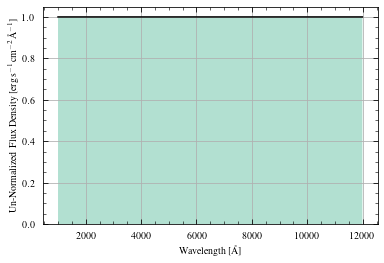

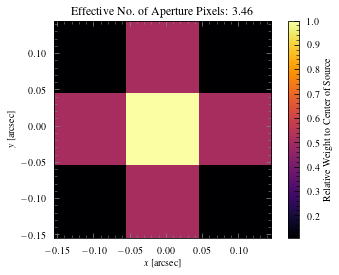

Time required for uv-band 4.645012657325591
SNR achieved in that time in uv-band 5.0

Time required for u-band 2.989409894582009
SNR achieved in that time in u-band 4.999999999999999

Time required for g-band 2.8217155696775826
SNR achieved in that time in g-band 5.0



In [2]:
#
# Define telescope instance
#
MyTelescope = Telescope(
    px_scale=0.1 * u.arcsec,
    phot_zpts=params.PHOT_ZPTS,
    passband_pivots=params.PASSBAND_PIVOTS,
)
#
# Generate background object
#
MyBackground = Background(mags_per_sq_arcsec=background_values.SKY_BACKGROUND)
MyBackground.add_geocoronal_emission(flux="avg")
#
# Create source
#
flux_profile = Profiles.uniform()
MySource = src.PointSource(flux_profile, angle=0.1 * u.arcsec)

wavelengths = np.arange(0.1, 1.2, 0.001) * u.um
MySource.generate_uniform(wavelengths=wavelengths, value=1.0)  # (in erg/s/cm^2/A)
fig, ax = plt.subplots()
ax.plot(MySource.wavelengths.value, MySource.spectrum, "k")
ax.fill_between(MySource.wavelengths.value, MySource.spectrum, alpha=0.5)
ax.set_xlabel("Wavelength [\AA]")
ax.set_ylabel(r"Un-Normalized Flux Density [$\rm erg\, s^{-1}\, cm^{-2}\,$\AA$^{-1}$]")
ax.set_ylim(bottom=0)
plt.show()

_show_weights = True
for band in MyTelescope.passbands:
    MySource.norm_to_value(
        22.0,
        "mag",
        passband_lims=MyTelescope.passband_limits[band],
        pivot_wavelength=MyTelescope.passband_pivots[band],
    )
    MyPhot = Photometry(MyTelescope, MySource, MyBackground)
    MyPhot.use_optimal_aperture(quiet=True)
    if _show_weights:
        MyPhot.show_source_weights(mark_source=False, source_markersize=4)
        _show_weights = False  # only display once
    result1 = MyPhot.calc_snr_or_t(snr=5, include_redleak=False)[band]
    print(f"Time required for {band}-band", result1)
    result2 = MyPhot.calc_snr_or_t(t=result1, include_redleak=False)[band]
    print(f"SNR achieved in that time in {band}-band", result2)
    print()


### Blackbody Spectrum with Redleak

Also automatically calculate photometric zero-points and passband pivot wavelengths.


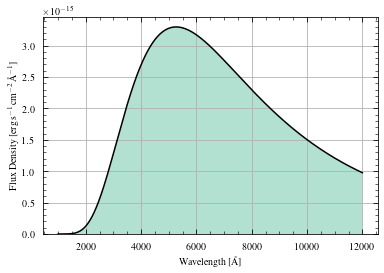

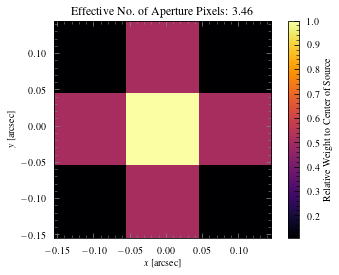

Time required for uv-band 3.820224947724621
SNR achieved in that time in uv-band 5.000000000000001

Time required for u-band 3.5918451919598606
SNR achieved in that time in u-band 5.0

Time required for g-band 2.8583879884070753
SNR achieved in that time in g-band 5.000000000000001



In [3]:
#
# Define telescope instance
#
MyTelescope = Telescope()
#
# Generate background object
#
MyBackground = Background(mags_per_sq_arcsec=background_values.SKY_BACKGROUND)
MyBackground.add_geocoronal_emission(flux="avg")
#
# Create source
#
flux_profile = Profiles.uniform()
MySource = src.PointSource(flux_profile, angle=0.1 * u.arcsec)

wavelengths = np.arange(0.1, 1.2, 0.001) * u.um
MySource.generate_bb(5500 * u.K)  # (in erg/s/cm^2/A)
MySource.show_spectrum()

_show_weights = True
for band in MyTelescope.passbands:
    MySource.norm_to_value(
        22.0,
        "mag",
        passband_lims=MyTelescope.passband_limits[band],
        pivot_wavelength=MyTelescope.passband_pivots[band],
    )
    MyPhot = Photometry(MyTelescope, MySource, MyBackground)
    MyPhot.use_optimal_aperture(quiet=True)
    if _show_weights:
        MyPhot.show_source_weights(mark_source=False, source_markersize=4)
        _show_weights = False  # only display once
    result1 = MyPhot.calc_snr_or_t(snr=5, include_redleak=True)[band]
    print(f"Time required for {band}-band", result1)
    result2 = MyPhot.calc_snr_or_t(t=result1, include_redleak=True)[band]
    print(f"SNR achieved in that time in {band}-band", result2)
    print()


## Extended Source


### Galaxy

This time, use sky background spectra instead of sky background magnitudes.

(Still need to load galaxy spectra. Use BB for now)


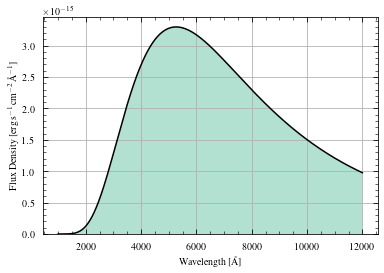

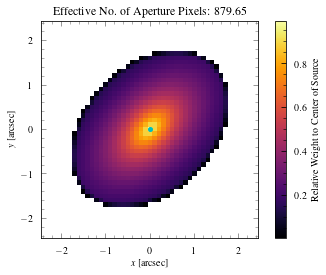

Time required for uv-band 4244.175435292433
SNR achieved in that time in uv-band 49.99999999999999

Time required for u-band 5440.389218918314
SNR achieved in that time in u-band 50.0

Time required for g-band 8063.061526208839
SNR achieved in that time in g-band 50.0



In [4]:
#
# Define telescope instance
#
MyTelescope = Telescope()
#
# Generate background object
#
MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="avg")
#
# Create source
#
flux_profile = Profiles.sersic(r_eff=2 * u.arcsec, n=1, e=0.4, angle=45)
MySource = src.ExtendedSource(flux_profile, angle_a=4 * u.arcsec, angle_b=4 * u.arcsec)

wavelengths = np.arange(0.1, 1.2, 0.001) * u.um
MySource.generate_bb(5500 * u.K)  # (in erg/s/cm^2/A)
MySource.show_spectrum()

_show_weights = True
for band in MyTelescope.passbands:
    MySource.norm_to_value(
        22.0,
        "mag",
        passband_lims=MyTelescope.passband_limits[band],
        pivot_wavelength=MyTelescope.passband_pivots[band],
    )
    MyPhot = Photometry(MyTelescope, MySource, MyBackground)
    MyPhot.use_elliptical_aperture(
        a=2 * u.arcsec, b=1.4 * u.arcsec, center=[0, 0] * u.arcsec, rotation=45
    )
    if _show_weights:
        MyPhot.show_source_weights(mark_source=True, source_markersize=4)
        _show_weights = False  # only display once
    result1 = MyPhot.calc_snr_or_t(snr=50, include_redleak=True)[band]
    print(f"Time required for {band}-band", result1)
    result2 = MyPhot.calc_snr_or_t(t=result1, include_redleak=True)[band]
    print(f"SNR achieved in that time in {band}-band", result2)
    print()
